### Step1: Dataset Preparation

In [1]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
p=Path("../../Datasets/Images/images")
print(type(p))

<class 'pathlib.PosixPath'>


In [3]:
dirs=p.glob("*")
image_data=[]
labels=[]
labels_dict={"cat":0,"dog":1,"horse":2,"human":3}

for folder_name in dirs:
    print(folder_name)
    label=str(folder_name).split("/")[-1][:-1]
    print(label)
    for img_path in folder_name.glob("*.jpg"):
        img=image.load_img(img_path,target_size=(32,32))
        img_array=image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

../../Datasets/Images/images/horses
horse
../../Datasets/Images/images/dogs
dog
../../Datasets/Images/images/cats
cat
../../Datasets/Images/images/humans
human


In [4]:
print(len(image_data),len(labels))

808 808


In [5]:
#Convert this data into numpy array
image_data=np.array(image_data,dtype='float32')/255.0
labels=np.array(labels)
print(image_data.shape,labels.shape)

(808, 32, 32, 3) (808,)


### Step2: Visualize this data

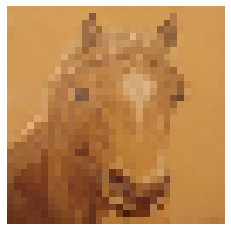

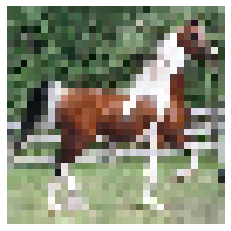

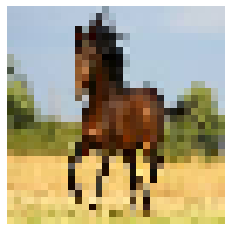

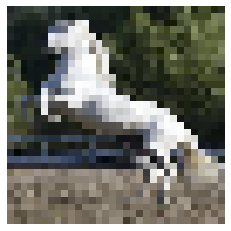

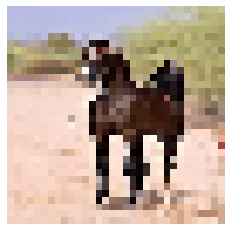

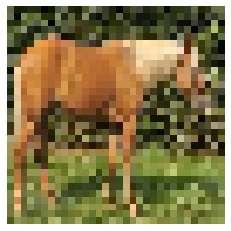

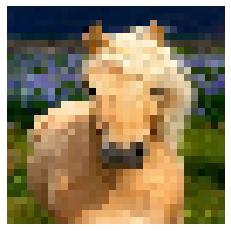

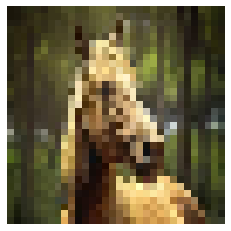

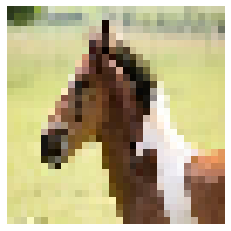

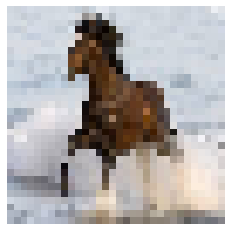

In [7]:
import matplotlib.pyplot as plt
def drawImg(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return
    
for i in range(10):
    drawImg(image_data[i])    

### Step3: Randomly shuffle data

In [8]:
import random
#zip
combined=list(zip(image_data,labels))

random.shuffle(combined)

#unzip
image_data[:],labels[:]=zip(*combined)

### Step4: Make SVM classifier class

In [9]:
#Make a class that implements SVM
class SVM:
    def __init__(self,c=1.0):
        self.c=c
        self.w=0
        self.b=0
        
    def hingeLoss(self,W,bias,X,Y):
        loss=0.0
        loss+=0.5*np.dot(W,W.T)
        
        m=X.shape[0]
        for i in range(m):
            ti=Y[i]*(np.dot(W,X[i].T)+bias)
            loss+=self.c*max(0,1-ti)
            
        return loss[0][0]    
    
    def fit(self,X,Y,batch_size=100,learning_rate=0.001,max_itr=300):
        no_of_features=X.shape[1]
        no_of_samples=X.shape[0]
        
        n=learning_rate
        c=self.c
        
        #Init the model parameters
        W=np.zeros((1,no_of_features))
        bias=0
        
        #Initial loss
        print(self.hingeLoss(W,bias,X,Y)) 
        
        #Training from here... using Mini Batch Gradient Descent
        losses=[]
        
        #training loop
        for it in range(max_itr): 
            l=self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            
            #Shuffle
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                
                #assume 0 gradient for batch
                gradW=0
                gradb=0
                
                #interate over all examples in mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i=ids[j]
                        ti=Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>=1:
                            gradW+=0
                            gradb+=0
                            
                        else:
                            gradW+=c*Y[i]*X[i]
                            gradb+=c*Y[i]

                #Gradient of batch is ready-- Update W,b
                W = W - n*W + n*gradW
                bias = bias + n*gradb
                
        self.w=W
        self.b=bias
        return W,bias,losses
                            
        

### Step5: Convert data for one vs one classification

In [10]:
print(image_data.shape,labels.shape)
M = image_data.shape[0]
image_data=image_data.reshape((M,-1))
print(image_data.shape)

(808, 32, 32, 3) (808,)
(808, 3072)


In [11]:
CLASSES=len(np.unique(labels))
print(CLASSES)

4


In [12]:
def classWiseData(x,y):
    data={}
    
    for i in range(CLASSES):
        data[i]=[]
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k]=np.array(data[k])
        
    return data            

In [13]:
data=classWiseData(image_data,labels)
print(data[0].shape[0])
print(data[1].shape)

202
(202, 3072)


In [14]:
def getDataPairForSVM(d1,d2):
    l1,l2=d1.shape[0],d2.shape[0]
    samples=l1+l2
    features=d1.shape[1]
    
    data_pair=np.zeros((samples,features))
    data_labels=np.zeros((samples,))
    
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    data_labels[:l1]=-1
    data_labels[l1:]=1
    
    return data_pair,data_labels

##  Implementing one vs one scheme : Training nC2 SVM classifiers

404.0


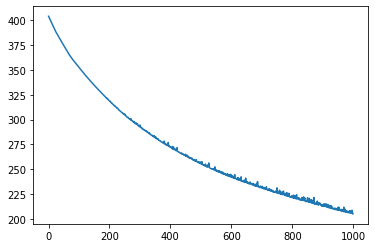

In [15]:
mySVM  = SVM()
xp, yp  = getDataPairForSVM(data[0],data[1])
w,b,loss  = mySVM.fit(xp,yp,learning_rate=0.00001,max_itr=1000)
#print(loss)
plt.plot(loss)

### Step6: Store weights of nC2 classifiers in 2D matrix

In [16]:
def trainSVMs(data):
    svm_classifiers={}
    
    for i in range(CLASSES):
        svm_classifiers[i]={}
        
        for j in range(i+1,CLASSES):
            xpair,ypair=getDataPairForSVM(data[i],data[j])
            mySVM=SVM()
            wts,b,loss=mySVM.fit(xpair,ypair,learning_rate=0.00001,max_itr=1000)
            plt.plot(loss,label="{},{}".format(i,j))
            plt.legend()
            plt.show()
            svm_classifiers[i][j]=(wts,b)
            
    return svm_classifiers        

404.0


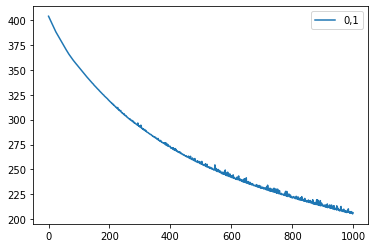

404.0


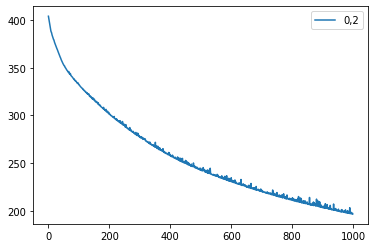

404.0


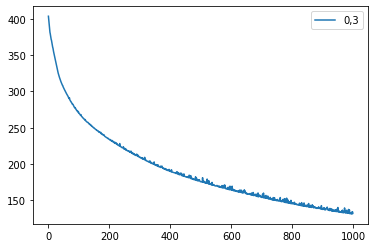

404.0


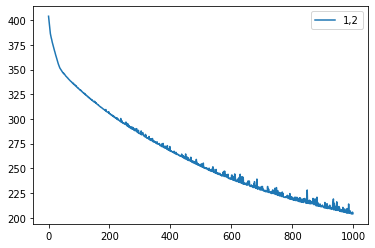

404.0


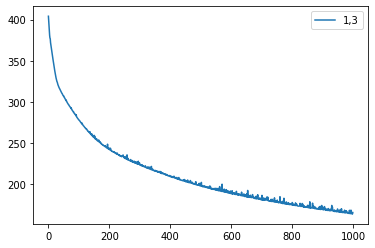

404.0


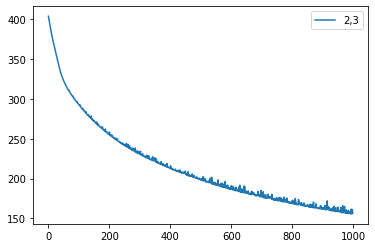

In [17]:
svm_classifiers=trainSVMs(data)

In [18]:
cats_dogs=svm_classifiers[0][1]
print(cats_dogs[0].shape)  #wts
print(cats_dogs[1].shape)  #bias- a scaler
print(cats_dogs)

(1, 3072)
()
(array([[ 0.01284452,  0.03385773,  0.02584499, ..., -0.00433277,
         0.02546681,  0.01529246]]), 0.005389999999999984)


### Step7: Prediction

In [19]:
def binaryPredict(x,w,b):
    z=np.dot(x,w.T)+b
    if z>=0:
        return 1
    else:
        return -1
    
def predict(x):
    count=np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b=svm_classifiers[i][j]
            z=binaryPredict(x,w,b)
            if z==1:
                count[j]+=1
            else:
                count[i]+=1
                
    final_prediction=np.argmax(count)
    return final_prediction

In [20]:
print(predict(image_data[0]))
print(labels[0])

2
2


### Step8: Calculate accuracy

In [21]:
def accuracy(x,y):
    count=0
    for i in range(x.shape[0]):
        prediction=predict(x[i])
        if prediction==y[i]:
            count+=1
    
    return count/x.shape[0]

In [22]:
accuracy(image_data,labels)

0.6237623762376238

### Check accuracy of sklearn svm

In [24]:
from sklearn import svm
svm_classifier=svm.SVC(kernel='linear',C=1.0)
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.6658415841584159